In [397]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np
import graphviz as gr 
from matplotlib import style 
import seaborn as sns 
from matplotlib import pyplot as pyplot

color=['0.3', '0.5', '0.7', '0.5']
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

pd.set_option('display.max_rows', 6)

In [398]:
data = pd.read_csv('data/cross_sell_email.csv')
data.head()

,gender,cross_sell_email,age,conversion
0,0,short,15,0
1,1,short,27,0
2,1,long,17,0
3,1,long,34,0
4,1,no_email,14,0


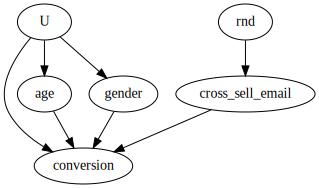

In [399]:
# Causal graphs
g_cross_sell = gr.Digraph()                 # directed graph using graphviz

g_cross_sell.edge("U", "conversion")        # unobserved node to conversion
g_cross_sell.edge("U", "age")
g_cross_sell.edge("U", "gender")

g_cross_sell.edge("rnd", "cross_sell_email")
g_cross_sell.edge("cross_sell_email", "conversion")
g_cross_sell.edge("age", "conversion")
g_cross_sell.edge("gender", "conversion")

g_cross_sell

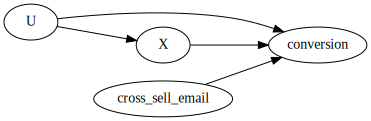

In [400]:
g_cross_sell = gr.Digraph(graph_attr={'rankdir': 'LR'})

g_cross_sell.edge('U', 'conversion')
g_cross_sell.edge('U', 'X')                 # observable nodes bundled into X

g_cross_sell.edge('cross_sell_email', 'conversion')
g_cross_sell.edge('X', 'conversion')

g_cross_sell

#### Querying a Graph in Python

A d-separating set in a DAG is a set of nodes that blocks all paths between the two sets. In other words, d-separation implies conditional independence in probability distributions. The condition is the third node set.

Parent nodes in an immorality structure are independent but when you condition on the collider (or even the collider's descendent), association flows between the parent nodes. d-separation is another way of expressing the independence between two variables, and to condition on a variable, just add it to the observed set.

Association flows in a chain, so nodes at either end of a chain are not independent (aka are dependent). However if you condition on the intermediary variable, you block the flow of association.

Association flows through a fork, so the descending nodes are not independent. However if you condition on the common cause, the path of association is blocked.

In [401]:
import networkx as nx 

model = nx.DiGraph([
    ("C", "A"),
    ("C", "B"),
    ("D", "A"),
    ("B", "E"),
    ("F", "E"),
    ("A", "G")
])

In [402]:
model.nodes

NodeView(('C', 'A', 'B', 'D', 'E', 'F', 'G'))

In [403]:
labels = {i: i for i in model.nodes}
labels

{'C': 'C', 'A': 'A', 'B': 'B', 'D': 'D', 'E': 'E', 'F': 'F', 'G': 'G'}

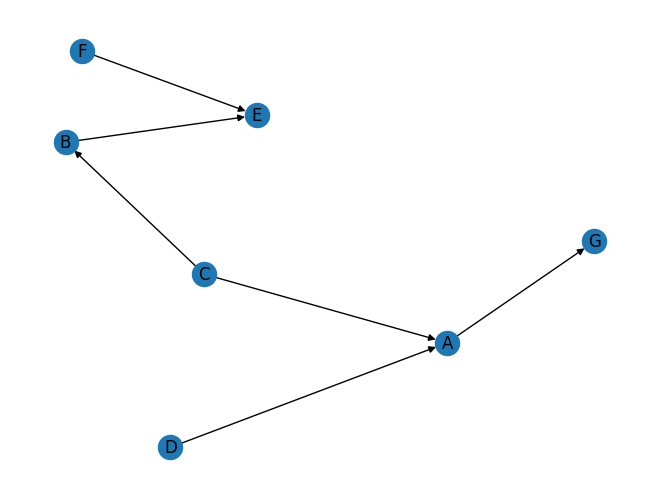

In [404]:
np.random.seed(23)
nx.draw(model, labels=labels, arrowsize=10)

In [405]:
# Immorality parent nodes are independent as is
print("Are D and C independent")
print(nx.d_separated(model, {"D"}, {"C"}, {})) # 

Are D and C independent
True


In [406]:
# Immorality conditioned on collider : parent nodes become dependent
print("Are D and C independent given A")
print(nx.d_separated(model, {"D"}, {"C"}, {"A"})) # 

Are D and C independent given A
False


In [407]:
# Immorality conditioned on collider descendent : parent nodes become dependent
print("Are D and C independent given G")
print(nx.d_separated(model, {"D"}, {"C"}, {"G"})) # 

Are D and C independent given G
False


In [408]:
# Chain : nodes at end are dependent
print("Are D and G independent")
print(nx.d_separated(model, {"D"}, {"G"}, {}))

Are D and G independent
False


In [409]:
# Chain conditioned on mediator : nodes at end become independent
print("Are D and G independent given A")
print(nx.d_separated(model, {"D"}, {"G"}, {"A"}))

Are D and G independent given A
True


In [410]:
# Fork : denscendent nodes are dependent as is 
print("Are A and B independent")
print(nx.d_separated(model, {"A"}, {"B"}, {}))

Are A and B independent
False


In [411]:
# Fork conditioned on common cause (confounder) : descendant nodes become independent
print("Are A and B independent given C")
print(nx.d_separated(model, {"A"}, {"B"}, {"C"}))

Are A and B independent given C
True


To put associations from chains, forks and immorality structures together, look at G and F. Does association flow through them?. Association flows between G and E, since they are in a fork (common cause is C). However, association stops at E because its a collider. Yet if you condition on E, association starts to flow through the collider and the path opens, connecting G and F.

In [412]:
# Put it all together
print("Are G and F independent")
print(nx.d_separated(model, {"G"}, {"F"}, {}))

Are G and F independent
True


In [413]:
# Put it all together
print("Are G and F independent given E")
print(nx.d_separated(model, {"G"}, {"F"}, {"E"}))

Are G and F independent given E
False


#### Identification Revisited

If you have a graph that depicts the causal relationship between treatment, outcome and other relevant variables, identification becomes the process of isolating the causal relationship between the treatment and the outcome in the graph. During identification, all undesirable flows of association are closed. You can check for bias by creating a causal graph but with the causal relationship removed. If treatment and outcome are still connected, it must be a noncausal path, which indicates the prescence of bias.

In the consultancy example, there are two association flows between treatment (consultancy) and the outcome (profits_next_6m). There is the direct causal path and the backdoor noncausal path that is confounded by a common cause (fork). The presence of a confounding backdoor path demonstrates that the observed association between consultancy and future company performance cannot be solely attributed to a causal relationship ie association is not causation.  

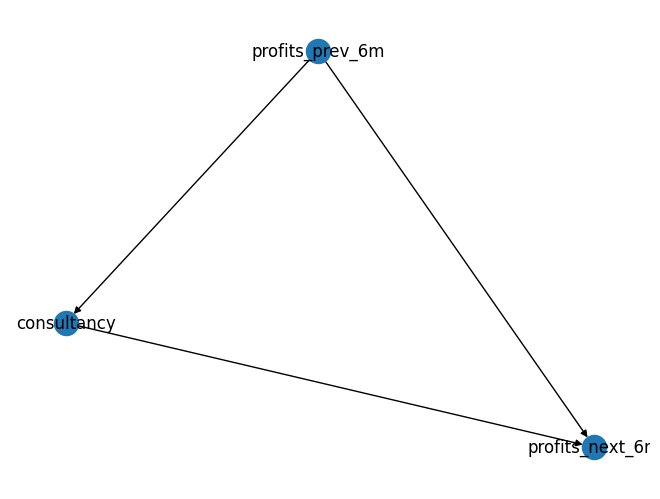

In [414]:
consultancy_model = nx.DiGraph([
    ("profits_prev_6m", "profits_next_6m"),
    ("profits_prev_6m", "consultancy"),
    ("consultancy", "profits_next_6m") # causal relationship removed
])
np.random.seed(23)
labels = {i:i for i in consultancy_model.nodes}
nx.draw(consultancy_model, labels=labels)

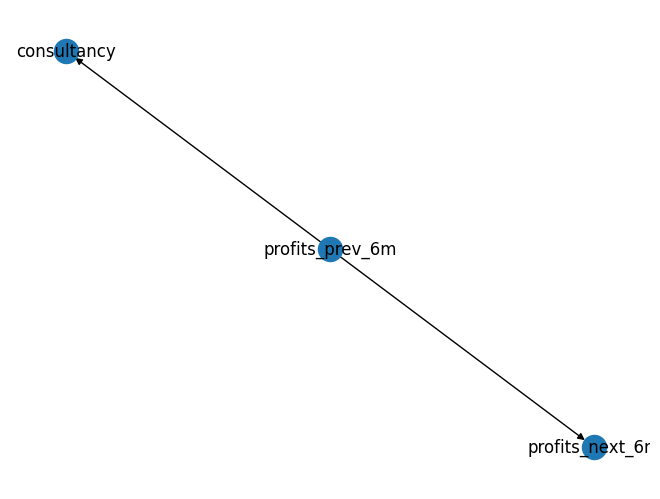

In [415]:
consultancy_model_severed = nx.DiGraph([
    ("profits_prev_6m", "profits_next_6m"),
    ("profits_prev_6m", "consultancy"),
    #("consultancy", "profits_next_6m") # causal relationship we're interested in
])
np.random.seed(23)
labels = {i:i for i in consultancy_model_severed.nodes}
nx.draw(consultancy_model_severed, labels=labels)

In [416]:
# Using not to check for dependence (not independent) between treatment and outcome
not(nx.d_separated(consultancy_model_severed, {"consultancy"}, 
                   {"profits_next_6m"}, {})) # still dependent after removing causal relationship, bias detected

True

#### Identification

Identification refers to the process of figuring out how to recover causal quantities from observable data. Identification is that the solution to the fundamental problem of causal inference. Identification is related to the idea of independence in a causal graph that contains the outcome, treatment and other relevant variables. Identification can thus be seen as the process of isolating the causal relationship between the outcome and treatment in the causal graph. Identification can also be seen as the process of getting rid of bias. To identify the causal relationship, you need to close backdoor paths so that only the causal path remains. 

Typically, an immorality describes selection bias, where treatment and outcome are parent nodes, and self selection as the common effect. So, the treatment causes self selection, and the outcome causes self selection. Self selection also typically happens out of the experimenter's hand, and as such association flows between the treatment and the outcome, violating the independence assumption. Treating selection bias is really difficult, since it involves undoing something that has happened. Again, a fork typically describes a situation where the treatment and outcome are descendant nodes, meaning association flows through them and breaking their dependence means finding adequate common causes and conditioning on them.

In the consultancy example (fork), conditioning on the  common cause, the company's past performance, closes that path. In other words, if you look at a group of companies with similar past performance and inside that group, compare future performance of those that hired consultants with those that didn't the difference can be entirely attributed to the consultants. This is an example of an assumption called the conditional independence association (CIA).

$(Y_0, Y_1)\;⊥\; T | X$ 

#### Conditional Independence Assumption (CIA), Adjustment Formula, Positivity Assumption.

The conditional Independence assumption (CIA) states that, if you compare units with the same level of covariate X their potential outcomes will be on average, the same (independence). The CIA motivates a simple way to identify causal effect from observable quantities in the data. If treatment looks as good as random within groups of feature X, all you need to do is compare treated and untreated inside each of the X defined groups and average the result using the size of the groups as weights:

$ATE = E_X[E[Y|T=1] - E[Y|T=0]]$  - note that expectation simply means a proportion / probability weighted sum

$ATE=\Sigma_x [ {(E[Y|T=1,X=x]-E[Y|T=0,X=x])P(X=x)} ]$

$ATE=\Sigma_x [ E[Y|T=1,X=x]P(X=x)-E[Y|T=0,X=x]P(X=x) ]$

This is called the adjustment formula or conditionality principle. It says that if you condition on, or control for X, the average treatment effect can be identified as the weighted average of in-group differences between treated and control. That is, if conditioning on X blocks the flow of association through the noncausal paths in the graph, a causal quantity, like ATE, becomes identifiable, meaning that you can compute it from observable data. The proces of closing backdoor paths by adjusting for confounders is called backdoor adjustment.

Since we are averaging the difference between treatment and control over X, you must ensure, that for all groups of X, there are some units in the treatment, and some in the control, otherwise the difference is undefined. Formally, the conditional probability of treatment needs to be strictly positive and below 1: $1>P(T|X)>0$. The positivity assumption is also called common support or overlap.

In [417]:
df = pd.DataFrame(dict(
    profits_prev_6m=[1.0,1.0,1.0,5,5,5],
    consultancy=[0,0,1,0,1,1],
    profits_next_6m = [1,1.1,1.2, 5.5, 5.7, 5.7],
))
df

,profits_prev_6m,consultancy,profits_next_6m
0,1.0,0,1.0
1,1.0,0,1.1
2,1.0,1,1.2
3,5.0,0,5.5
4,5.0,1,5.7
5,5.0,1,5.7


In [418]:
# naively compare just based on treatment (there are biases due to confounder of past performance)
(df.query("consultancy==1")['profits_next_6m'].mean() -
 df.query("consultancy==0")['profits_next_6m'].mean())

1.666666666666667

In [419]:
# comparing companies that have similar past performance
avg_df = (df.groupby(["consultancy", "profits_prev_6m"])['profits_next_6m'].mean())
avg_df

consultancy  profits_prev_6m
0            1.0                1.05
             5.0                5.50
1            1.0                1.20
             5.0                5.70
Name: profits_next_6m, dtype: float64

In [420]:
# for each group of profits_prev_6m, subtracted treated from untreated
avg_df.loc[1] - avg_df.loc[0]  # subtract consultancy=1 from consultancy=0

profits_prev_6m
1.0    0.15
5.0    0.20
Name: profits_next_6m, dtype: float64

In [421]:
# ATE
(avg_df.loc[1] - avg_df.loc[0]).mean()

0.17500000000000004

#### Selection Bias - Conditioning on a Collider

We know that in an immorality, nodes that share a common effect are independent until you condition on the common effect, in which case they become dependent. Take the example where a software company randomly rolls out new features and then follows it up with surveys. Randomization allows that we can calculate ATE as the difference between treated and control groups, but since we only have access to the score of the surveys that were returned, we have essentially conditioned on response. There are customers who were already satisfied with the product; and customers whose current improvement in product satisfaction is due to the new feature rollout. We would like to measure the increase in satisfaction due to the new feature rollout via the surveys. 

Customers that received the new feature are more likely to respond to the surveys; customers that were already satisfied to the product are also more likely to respond to the surveys. That is response to the survey, is a collider resulting from new feature and satisfaction (not to mention the association that flows between new feature and satisfaction). The association flow from new feature to customer satisfaction to survey score is the causal path we are interested in (where customer satisfaction is a chain mediator). By conditioning on those who responded to the surveys, we have introduced selection bias to our analysis, by introducing association between new feature and survey score that isnt due to the causal path. RND is randomization, NPS is net promoter score.

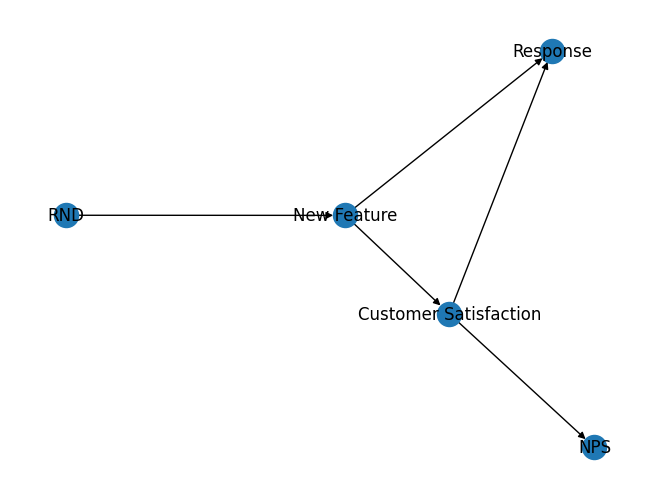

In [422]:
np.random.seed(1)
nps_model = nx.DiGraph([
    ("RND", "New Feature"),
    ("New Feature", "Customer Satisfaction"),
    ("Customer Satisfaction", "NPS"),
    ("Customer Satisfaction", "Response"),
    ("New Feature", "Response")
])
labels = {i:i for i in nps_model.nodes}
nx.draw(nps_model, labels=labels)

In [423]:
# Is there association between NPS and New Feature, after conditioning on Response
not(nx.d_separated(nps_model, {"NPS"}, {"New Feature"}, {"Response"}))

True

In [424]:
np.random.seed(2)
n = 100000
new_feature = np.random.binomial(1, 0.5, n)     # n single-trial yes/no answers of receiving new feature

satisfaction_0 = np.random.normal(0, 0.5, n)    # potential satisfaction of all participants with no treatment
satisfaction_1 = satisfaction_0 + 0.4           # potential satisfaction of all participants with treatment
satisfaction = new_feature*satisfaction_1 + (1-new_feature)*satisfaction_0 # observed satisfaction 

nps_0 = np.random.normal(satisfaction_0, 1)         # potential survey score; no treatment 
nps_1 = np.random.normal(satisfaction_1, 1)         # potential survey score; treatment 
nps = new_feature*nps_1 + (1-new_feature)*nps_0     # observed survey score

responded = (np.random.normal(0 + new_feature + satisfaction, 1) > 1).astype(int)   # responded to survey?

tr_df = pd.DataFrame(dict(new_feature=new_feature,  # did they get the new feature rollout?
                          responded=responded,      # did they respond to survey
                          nps_0=nps_0,              # potential survey score; no treatment
                          nps_1=nps_1,              # potential survey score; with treatment
                          nps=nps))                 # observed survey score

tr_df_measureable = pd.DataFrame(dict(new_feature=new_feature,  # did they get the new feature rollout?
                                      responded=responded,      # did they respond to survey
                                      nps_0=np.nan,             # unmeasurable potential outcome, no treatment
                                      nps_1=np.nan,             # unmeasurable potential outcome, with treatment
                                      nps=np.where(responded, nps, np.nan)))    # only have nps for respondents

tr_df.groupby("new_feature").mean()     

,responded,nps_0,nps_1,nps
new_feature,,,,
0,0.183715,-0.005047,0.395015,-0.005047
1,0.639342,-0.005239,0.401082,0.401082


In [425]:
tr_df_measureable.groupby("new_feature").mean().assign(**{"nps":np.nan}) # filling nps vals with np.nan

,responded,nps_0,nps_1,nps
new_feature,,,,
0,0.183715,NaN,NaN,NaN
1,0.639342,NaN,NaN,NaN


In [426]:
tr_df_measureable["nps"].isna().sum() # we have NAN for non-respondents

58890

In [427]:
tr_df["nps"].isna().sum()   # our magic data with potential outcomes has no NAN

0

In [428]:
tr_df_measureable.groupby(["responded", "new_feature"]).mean()

nps_0  nps_1       nps
responded new_feature                        
0         0              NaN    NaN       NaN
          1              NaN    NaN       NaN
1         0              NaN    NaN  0.314073
          1              NaN    NaN  0.536106

In [430]:
tr_df.groupby(["responded", "new_feature"]).mean()

nps_0     nps_1       nps
responded new_feature                              
0         0           -0.076869  0.320616 -0.076869
          1           -0.234852  0.161725  0.161725
1         0            0.314073  0.725585  0.314073
          1            0.124287  0.536106  0.536106

When you condition on those who responded, you find that $E[Y_0|T=0,R=1] > E[Y_0|T=1, R=1]$ .That is the control and treated groups which were comparable in terms of their baseline statisfaction (we have godlike powers where we see potential outcomes even for those who didnt respond) $E[Y_0|T=0] = E[Y_0|T=1]$, but once you condition on those who responded the survey $R=1$, the treatment group has lower baseline satisfaction.  This means a simple difference in averages between treated and control does not identify the ATE, once you condition on those who responded.

$E[Y_1|T=1, R=1] - E[Y_0|T=1, R=1]$   -- observed - unobserved potential difference 

= $E[Y_1|T=1, R=1] - E[Y_0|T=1, R=1] +  E[Y_0|T=0, R=1] - E[Y_0|T=0, R=1]$ 

= $E[Y_1|T=1, R=1] - E[Y_0|T=0, R=1] +  E[Y_0|T=0, R=1] - E[Y_0|T=1, R=1]$ 

= $E[Y_1 - Y_0| R=1] +  E[Y_0|T=0, R=1] - E[Y_0|T=1, R=1]$ 

= $Observed\;ATE+Selection\;Bias$




In [437]:
0.536106 - 0.124287	

0.411819

In [439]:
0.536106 - 0.314073 + (0.314073 - 0.124287)

0.411819

#### Adjusting for Selection bias

Correcting selection bias is not trivial. Even with a randomized control trial, ATE may not be identifiable. To make some progress, you need to make further assumptions. For instance, you need to assume that outcome doesnt cause selection. You need to have some other observable variable(s) that cause selection and the outcome. Then you apply the adjustment formula by simply segmenting data into groups defined by covariate X so that treated and control groups become comparable within those segments. Then you compute the weighted average of the in-group comparison between treated and control, using the size of each group as the weights, all while conditioning on the selection variable.

$ATE=\Sigma_x{(E[Y|T=1, R=1,X] - E[Y|T=0, R=1, X])P(X|R=1)}$